# Domain-area Tests

Domain-area tests make use of domain-area knowledge. Since they require meaningful outputs, these tests are more likely to be integration tests, i.e. exercising  a number of unit-blocs of code at a time. They are also more likely  to take a fair amount of time to compute. As such they make break normal development rhythms, e.g. write some unit-block of code, write some test exercising it, check that the test works, rinse and repeat. And they are less likely to offer good bug diagnostic, e.g. if  one such test break, it may not always be clear why. However, since they capture actual expected results from the domain-area, once written and passing, they sooth the soul much more than unit-tests. Below we outline some common themes when writing such tests, and put them in the context of Lattice-Boltzmann.

## Symmetries are simple tests

One of the simplest domain-area tests we can perform is to check that expected symmetry relationships actually hold. For instance, lets look at a square box containing fluid particles with an initial velocity along one of the diagonal directions (one experimental realization would be a box of fluid in free fall hitting the floor right on one of its corners). We expect that the fluid will slosh around the box, respecting a symmetry axis along that same diagonal. More to the point, we expect that (scalar) physical quantities $q(x, y)$ will map to $q(y, x)$.

The following sets up this problem:

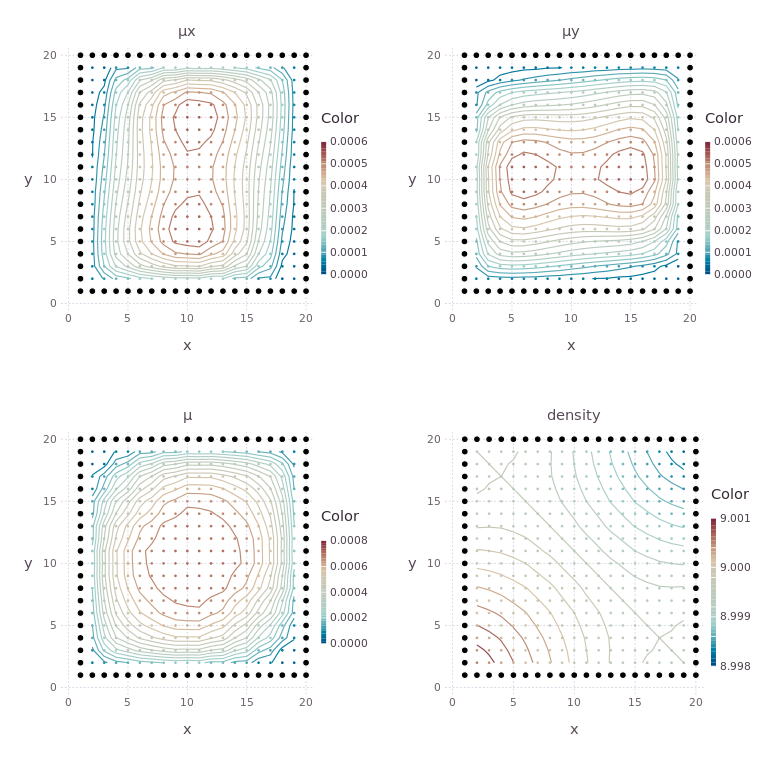

In [1]:
using LatBo
using Gadfly
# Plotting helper functions
include(joinpath(Pkg.dir("LatBo"), "extras", "SimplePlot.jl"))

# Sets up a square box with initial velocity μ₀
Npoints, δt, δx = (20, 20), 5e-4, 1e-3
sim = lbgk(:D2Q9, Npoints, δt, δx; viscosity=4e-1, μ₀ = 1e-2/√3.0 * δt/δx * [1, 1])
sim.playground[:] = Playground.SOLID
sim.playground[2:(end-1), 2:(end-1)] = Playground.FLUID

# Then computes flow for a number of steps
run!(sim, nsteps=60)

# Finally, plots momenum :mu, and :density, using helper function from LatBo
set_default_plot_size(8inch, 8inch * float(Npoints[2])/float(Npoints[1]))

theme = Theme(default_point_size=1pt, highlight_width=0pt)
vstack(
  hstack(plot(:μx, sim, theme), plot(:μy, sim, theme)),
  hstack(plot(:μ, sim, theme), plot(:density, sim, theme))
)

We see above the momentum along x and y, as well as the total momentum. The symmetries are fairly clear in the pictures. But we want to actually test them numerically. This brings in issues of accuracy and how to test floating point numbers. However, symmetries are often respected up to numerical precision. Indeed, that's why symmetries are so _easy_ to test. Either there is a compelling reason an algorithm breaks a symmetry - and it is a known "feature" of the algorithm from the outset - or the symmetry should emerge from the algorithm naturally.

In [2]:
using LatBo: density
using FactCheck: facts, @fact, roughly, context, not
facts("Fluid with [1, 1] velocity in closed square box: symmetry analysis") do
    context("density: ρ(x, y) ↦ ρ(y, x)") do
        ρ = density(sim)
        @fact ρ => roughly(transpose(ρ), 1e-16)
    end
    context("momentum") do
        μ = momentum(sim)
        μₓ, μy = squeeze(μ[1, :, :], 1), squeeze(μ[2, :, :], 1)       
        context("magnitude: |μ(x, y)| ↦ |μ(y, x)|") do
            magnitude = √(μₓ^2 + μy^2)
            @fact magnitude => roughly(transpose(magnitude), 1e-16)
        end
        context("vectorial: μₓ(x, y) ↦ μy(y, x)") do
            @fact μₓ => roughly(transpose(μy), 1e-16)
        end
        context("negative tests to check relationships that best not be") do
            @fact μₓ => not(roughly(μy))
            @fact μₓ => not(roughly(transpose(μₓ)))
        end
    end
end
nothing

Fluid with [1, 1] velocity in closed square box: symmetry analysis
     - density: ρ(x, y) ↦ ρ(y, x)
     - momentum
       - magnitude: |μ(x, y)| ↦ |μ(y, x)|
       - vectorial: μₓ(x, y) ↦ μy(y, x)
       - negative tests to check relationships that best not be
5 facts verified.


There are two simple ingredients here. First, we specifically setup the simulation with an input displaying a given symmetry. Then, we tested that the output recovers the same symmetry, despite that it is nowhere hard-coded into the algorithm. We were careful to choose an example where the symmetry is respected by the algorithm; if we rotate the box by 30 degrees while keeping the orientation of the discrete LB grid constant, then the LB algorithm (and the boundary conditions) break the symmetry we are looking for. The checks would have to take into account the degree of convergence with respect to the discrete grid, something quite a bit more challenging to setup. In the example above, we also setup some negative tests to try and avoid false positives (e.g. momentum is zero everywhere).

This test is not sufficient in itself; it could be that the momentum respect the symmetry of the input, but is orders of magnitude off. Nor would this test yield an easy diagnostic were something to go wrong. However, it does show that all the right bits are interacting (mostly) in all the right ways.

## Flow in a pipe

Domain-area 101 is generally where we want to look next for inspiration. In the case of fluid dynamics, that would likely be the Couette flow, or flow between parallel plates. It is standard enough to warrant its own [wikipedia page](http://en.wikipedia.org/wiki/Couette_flow). The setup is very simple; two plates parallel to the flow, an inlet and an outlet perpendicular to it:

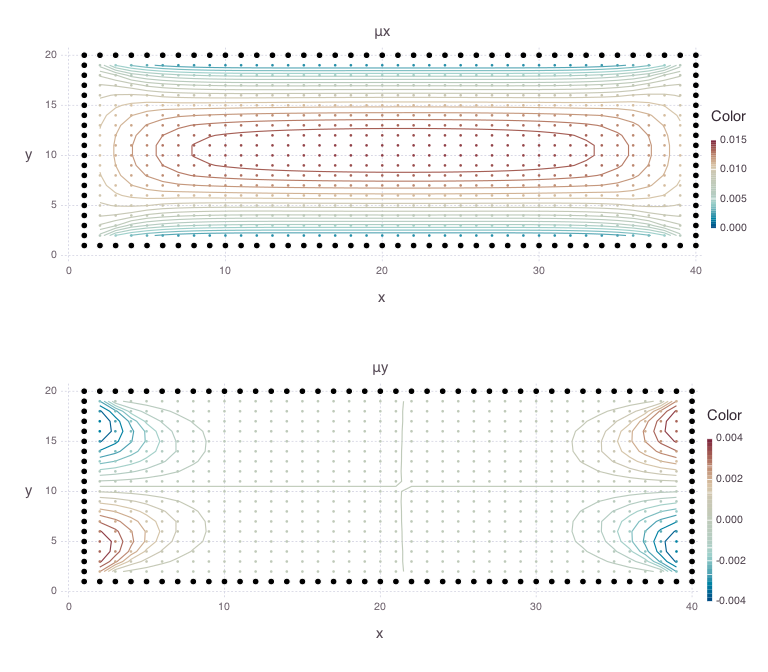

In [3]:
using LatBo
using Gadfly

Npoints, δt, δx = (40, 20), 5e-4, 1e-3
viscosity, p₀, Δp, μ₀=4e-1, 150, 100, 0.025*[1, 0]
sim = lbgk(:D2Q9, Npoints, δt, δx; viscosity=viscosity, p₀=p₀, Δp=Δp, μ₀=μ₀)
sim.playground[:] = Playground.SOLID
sim.playground[2:(end-1), 2:(end-1)] = Playground.FLUID
sim.playground[1, :] = Playground.INLET
sim.playground[end, :] = Playground.OUTLET

# Then computes flow for a number of steps
run!(sim, nsteps=80)

# Plotting helper functions
include(joinpath(Pkg.dir("LatBo"), "extras", "SimplePlot.jl"))
# Finally, plots momentum :mu, and :density, using helper function from LatBo
set_default_plot_size(8inch, 7inch)

theme = Theme(default_point_size=1pt, highlight_width=0pt)
vstack(plot(:μx, sim, theme), plot(:μy, sim, theme))

The fluid should be strictly parallel to the plates ($\mu_y=0$), with a parabolic velocity profile $\mu_x \backsim \frac{\Delta P}{\nu} (y^2-h^2)$, where $\Delta P$ is the pressure gradient and $\nu$ the viscosity. The velocity profile at the inlet and at the outlet are inputs. In the case of the simulation setup here, the _inlet_ and _outlet_ do not exhibit the parabolic velocity profiles. This way, the simulation will not be coerced to exhibit those behaviours we are checking for. Rather, if all goes well, the expected profile will appear of itself when sufficiently far from either end. The cost, however, is that the region between the two plates must be sufficiently long, and the simulation run long enough for the expected flow to establish itself. What all this implies is that we will have to be careful to converge results sufficiently.

What we want to do here is check that the relationships given above do hold:
- the profile is proportional to the difference in pressure between inlet and outlet
- the profile is parabolic with respect to y, maximum at the center, and (near) zero near the plates

The first item will require simulating the flow at least twice. As mentioned previously, these domain-area tests can be quite time-consuming, at least with respect to the mechanical/unit-tests presented earlier. 

There is a simple trick to measure linear behaviors, $f(\lambda x) = \lambda f(x)$. It comes down to simply running the code twice, with one simulation where the pressure is halved, and checking that the velocity profile is halved as well. It is not necessarily the most accurate method, but it goes to the heart of what we are checking for - linearity - with the minimum of fuss.

In [4]:
using FactCheck: @fact, facts, roughly, context
facts("Couette flow") do
    # Compute velocity alongst x
    vₓ = squeeze(velocity(sim)[1, :, :], 1)
    
    context("Velocity profile is linear with respect to ΔP") do
        sim_halved = lbgk(:D2Q9, Npoints, δt, δx; viscosity=viscosity, p₀=p₀-0.25Δp, Δp=0.5Δp, μ₀=0.5μ₀)
        sim_halved.playground[:] = sim.playground

        # Run the new simulation
        run!(sim_halved; nsteps=80)
        
        # Compare the flows sufficiently far from inlet/outlet and plates
        xᵣ = size(vₓ, 1)*1/4:size(vₓ, 1)*3/4
        yᵣ = 2:(size(vₓ, 2)-1)
        @fact  squeeze(velocity(sim_halved)[1, xᵣ, yᵣ], 1) => roughly(0.5vₓ[xᵣ, yᵣ], 1e-4)
    end
end
nothing

Couette flow
     - Velocity profile is linear with respect to ΔP
1 fact verified.


In Lattice-Boltzmann, the relationship between macroscopic quantities (pressure, in this test), boundary condition, and initial conditions can be a bit tricky. So this test is a bit finicky. We've made sure that the initial condition are consistent between two the calculations. Inevitably, there will always be situations where it is necessary to have a good understanding of the numerical method to test it correctly. The next test, however is both more general, and much more satisfyingly robust in its outcome.

To check that the profile is parabolic, we will use the package GLM (General Linear Models) in conjunction with the package DataFrames. These two packages are part of Julia's fancy statistics capabilities. The idea here is that linear regression can help us determine whether  $Ay^2  + B$ fits the velocity profile better than $A + By +  Cy^3 + Dy^4 + \dots$. We will avoid fitting values on the plate (at y=1 and y=20), since the velocities there are defined explicitly by the boundary condition. It makes the test a bit easier and no less valid.

In [5]:
Pkg.add("GLM"); Pkg.add("DataFrames")

using FactCheck: @fact, facts, roughly, context, less_than
using GLM
using DataFrames
facts("Couette flow") do
    # Compute velocity alongst x, enforcing boundary conditions
    vₓ = squeeze(velocity(sim)[1, :, :], 1)
 
    context("Velocity profile is parabolic") do
        # Centers y coordinates at pipe axis and avoid plate boundary
        y = ([0:size(vₓ, 2)-1] - (size(vₓ, 2) - 1)/2.0)[2:end-1]
        # Sets up data frame object
        data = DataFrame(y=y, y²=y.^2, y³=y.^3, y⁴=y.^4, y⁵=y.^5)
    
        for i = size(vₓ, 1) * 1/4: size(vₓ, 1)*3/4
            # velocity in the fluid (avoids solid at y=1, y=end)
            data[:vₓ] = squeeze(vₓ[i, :], 1)[2:end-1]
            # Computes fit of two linear models
            parabolic = glm(vₓ~1+y², data, Normal(), IdentityLink())
            non_parabolic = glm(vₓ~1+y+y³+y⁴+y⁵, data, Normal(), IdentityLink())
          
            @fact deviance(parabolic) => less_than(deviance(non_parabolic)/50)
        end
    end
end
nothing

INFO: Nothing to be done
INFO: Nothing to be done


Couette flow
     - Velocity profile is parabolic
21 facts verified.


This test confronts two models for the velocity profile. One model is parabolic and contains only two parameters (intercept and second order term). The other is non-parabolic, but allows for many more fitting parameters. The advantage here is that we focus on the property that we want to verify. We could, somewhat equivalently, figure out the exact analytical expression for this simulation. We could then convert the expression to use Lattice-Boltzmann _grid_ units. And finally, gauge whether or not the simulation conforms to the analytical expression. But this would be error prone: we would be comparing absolute quantities (the analytical results) to the imprecise results yielded by the simulation. The latter are subject to convergence issues with respect to the grid discretization, the run-up time until the simulation stabilizes to a steady flow, etc. By comparing parabolic and non parabolic models we cut through the noise and compare quantities from the same imprecise simulation. We certainly still need to worry about convergence problems. We are comparing real-life apples to real-life pears, with all their warts and worms, checking for the appleness of one versus the peareness of the other. What we do not do is measure real-life apples against some Platonic ideal. 